In [21]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### MLP- with Model training, learning rate tuning, hyperparameters, evaluation,

In [28]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [24]:
len(words)

32033

In [29]:
#build vocabulary of characters and mappings to/from intergers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [30]:
# build dataset WITH BLOCK SIZE = 3
block_size = 3
X, Y = [], []

for w in words[:5]:
    
	#print(w)
	context = [0] * block_size
	for ch in w + '.':
		ix = stoi[ch]
		X.append(context)
		Y.append(ix)
		print(''.join(itos[i] for i in context), '--->',itos[ix])
		context =context[1:] + [ix]

X= torch.tensor(X)
Y= torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


* Embeddings

In [31]:
# We create a 2 dimensional embedding since we only have 27 letters
C = torch.randn((27,2)) 
# There is two ways of creating the embedding
# first similar to the previous approach (One-hot)
emb1 = F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# one hot since is zeros a 1 it will plug out the fifth row by matrix multiplication
# Second - simply: 
emb2 = C[5]

print(emb1);print(emb2)

tensor([-0.1410, -0.5486])
tensor([-0.1410, -0.5486])


In [32]:
# Due too the properties of torch we can simply create the embedding by
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [33]:
#Now we want to transform this [len(words),3letters,2embedding]
#in simple [len(words),6] to feed the NN and do 
W1 = torch.randn((6,100))
b1 = torch.randn(100)
emb @ W1 + b1   ##    ---->   :S 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [34]:
# We fix this manipulating the matrix dimensions with .view()
emb.view(32, 6)

tensor([[ 0.0153, -0.6587,  0.0153, -0.6587,  0.0153, -0.6587],
        [ 0.0153, -0.6587,  0.0153, -0.6587, -0.1410, -0.5486],
        [ 0.0153, -0.6587, -0.1410, -0.5486,  0.1017,  2.8936],
        [-0.1410, -0.5486,  0.1017,  2.8936,  0.1017,  2.8936],
        [ 0.1017,  2.8936,  0.1017,  2.8936,  0.5883,  0.1524],
        [ 0.0153, -0.6587,  0.0153, -0.6587,  0.0153, -0.6587],
        [ 0.0153, -0.6587,  0.0153, -0.6587,  0.2144,  0.1225],
        [ 0.0153, -0.6587,  0.2144,  0.1225, -0.8557,  1.3832],
        [ 0.2144,  0.1225, -0.8557,  1.3832, -0.4992, -0.1814],
        [-0.8557,  1.3832, -0.4992, -0.1814,  1.4304,  1.4427],
        [-0.4992, -0.1814,  1.4304,  1.4427, -0.4992, -0.1814],
        [ 1.4304,  1.4427, -0.4992, -0.1814,  0.5883,  0.1524],
        [ 0.0153, -0.6587,  0.0153, -0.6587,  0.0153, -0.6587],
        [ 0.0153, -0.6587,  0.0153, -0.6587,  0.5883,  0.1524],
        [ 0.0153, -0.6587,  0.5883,  0.1524,  1.4304,  1.4427],
        [ 0.5883,  0.1524,  1.4304,  1.4

In [36]:
# To avoid hardcoded number we can use -1 so pytorch will fit only the last dim to our request (6) = (3letters x 2 embedding)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape
#boadcasting will do the correct thing 
# emb * w1 + v1
# [32,6] x [6,100] = [32,100] 
#  [32,100] + [1,100] = [32,100]

torch.Size([32, 100])

In [37]:
# Create next layer, output layer
W2 = torch.randn((100,27)) # 27 output letter 
b2 = torch.randn(27)

In [38]:
# So out output will be the logits
logits = h @ W2 + b2

In [39]:
counts = logits.exp()

In [40]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [41]:
prob[0].sum() # SHould be 1 since we've normalized this vector

tensor(1.0000)

In [42]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [43]:
# Get the probabilities of the correct next character
prob[torch.arange(32),Y]

tensor([7.8308e-06, 1.4037e-09, 3.6531e-08, 2.5313e-01, 5.8511e-14, 6.1517e-05,
        2.1973e-04, 2.1544e-04, 9.2984e-01, 2.2045e-15, 1.2845e-11, 2.8423e-14,
        1.1116e-11, 1.3589e-02, 3.3129e-03, 1.0572e-07, 3.1613e-07, 1.1634e-04,
        9.3968e-04, 6.6318e-06, 1.7523e-09, 1.0381e-07, 4.9307e-03, 9.7922e-01,
        4.5495e-11, 4.8965e-09, 4.0091e-05, 8.1552e-01, 1.5613e-07, 6.6243e-13,
        3.7811e-12, 9.4468e-01])

In [45]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(14.2782)

In [50]:
# -------------- Now made more respectable ----------
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [54]:
g = torch.Generator().manual_seed(214783674)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g) #6 = 3 letter * 2 embeddings
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

3481

In [56]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    # or simply use cross_entropy
    # this has the advantage of dealing with very large numbers that can lead .exp to go too far
    # pytroch will subtract the max value of the logits to avoid this and backward pass will be faster
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.2555687427520752


Since we only have 32 letter we are overfitting and almost getting 0 loss, we only dont get 0 since it's difficult to predict the first letter after "..." besides that eveyrything is very close:

In [58]:
logits.max(1)

torch.return_types.max(
values=tensor([ 8.6574, 14.4156, 14.7787, 14.6051, 13.3698,  8.6574, 12.6657, 14.0357,
        13.7471, 12.8055, 15.4202, 17.4647,  8.6574, 12.2926, 15.4662, 16.7973,
         8.6574, 13.4650, 13.2454, 12.9673, 14.7730, 10.9743, 13.7070, 18.2338,
        15.1285,  8.6574, 12.2235, 12.5467, 19.2489, 17.5169, 14.6914, 18.0540],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0, 15, 22,  1,  0, 15, 19,
         1,  2,  5, 12, 12,  1,  0, 15, 15, 16,  8,  9,  1,  0]))

In [59]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

indices os max counts are almost the same as Y

### Let's put all together for the enitre dataset!!

In [82]:
# Build dataset
def build_dataset(words):
	block_size = 3
	X, Y = [], []
	
	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			#print(''.join(itos[i] for i in context), '--->',itos[ix])
			context =context[1:] + [ix]

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


(torch.Size([182441, 3]), torch.int64, torch.Size([182441]), torch.int64)

In [155]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator = g)
W1 = torch.randn((6,100),generator = g) # 3letters(block size)x2 inputs
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

3481

* Implement mini-batch and Learning rate to address speed problems on the entire dataset

In [156]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lri = []
stepi = []
lossi = []

In [158]:
for i in range(1000):	

	# mini-batch construct with 32 examples of words 
	# although this is not the exact gradient its good enough to give the direction 
	# in which we should move to minimize the loss, then
	ix= torch.randint(0, Xtr.shape[0],(32,))

	# forward pass
	emb = C[Xtr[ix]] # (32, 3, 2)
	h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
	logits = h @ W2 + b2 # (32,27)
	loss = F.cross_entropy(logits, Ytr[ix])
	#print(loss.item())
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	#lr = 0.1 if i < 10000 else 0.01
	lr = lrs[i]
	for p in parameters:
		p.data += - lr * p.grad

	# track stats
	stepi.append(i)
	lri.append(lre[i])
	lossi.append(loss.item())
print(f'Batch loss:{loss.item()}')

Batch loss:6.506563663482666


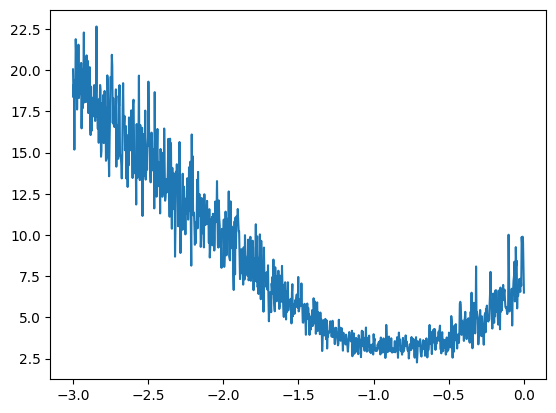

In [159]:
plt.plot(lri,lossi)

From the plot we can see that a good learning rate is 10**-1 = 0.1 as we had initially

In [110]:
# Run it again with the correct learning rate and also learning decay

In [160]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator = g)
W1 = torch.randn((6,200),generator = g) # 3letters(block size)x10 inputs
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

6881

In [151]:
lri = []
lossi= []
for i in range(10000):	

	# mini-batch construct with 32 examples of words 
	# although this is not the exact gradient its good enough to give the direction 
	# in which we should move to minimize the loss, then
	ix= torch.randint(0, Xtr.shape[0],(32,))

	# forward pass
	emb = C[Xtr[ix]] # (32, 3, 2)
	h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
	logits = h @ W2 + b2 # (32,27)
	loss = F.cross_entropy(logits, Ytr[ix])
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update 
	#lr = 0.1 if i < 10000 else 0.01 # learning decay
	lr = 0.05
	for p in parameters:
		p.data += - lr * p.grad

	# track stats
	stepi.append(i)
	#lri.append(lre[i])
	lossi.append(loss.item())
#print(f'Batch loss:{loss.item()}')

In [152]:
# evaluate on train set instead of the batch
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr)
print(f'train set loss:{loss}')

train set loss:2.3782036304473877


In [153]:
# evaluate on dev set 
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev)
print(f'dev set loss:{loss}')
# In this case the dev loss =~= train loss wich means that our
# NN is not overfitting, we can improve the test loss by 
# increasing the size of NN until train loss == dev loss
# 100 neurons -> train loss= 2.43, dev loss = 2.6
# 200 neuros -> train loss= 2.278, dev loss = 2.38

dev set loss:2.382650375366211


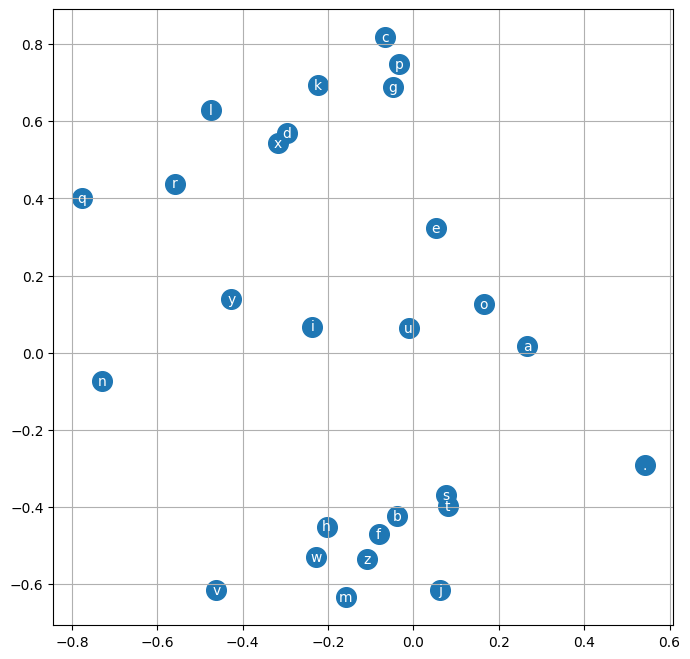

In [154]:
# Prbabily now the bottleneck is not the size of the NN but the fact of only using 2 embeddings
# visualizing the embeddings 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

Interesting how the vogals are all together :) the NN think they ar every similar

In [181]:
# scale number of embeddings to 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator = g)
W1 = torch.randn((30,200),generator = g) # 3letters(block size)x10 inputs
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

11897

In [182]:
lri = []
lossi= []
stepi= []

In [183]:
for i in range(200000):	

	# mini-batch construct with 32 examples of words 
	# although this is not the exact gradient its good enough to give the direction 
	# in which we should move to minimize the loss, then
	ix= torch.randint(0, Xtr.shape[0],(32,))

	# forward pass
	emb = C[Xtr[ix]] # (32, 3, 2)
	h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
	logits = h @ W2 + b2 # (32,27)
	loss = F.cross_entropy(logits, Ytr[ix])
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update 
	if i < 10000:
		lr = 0.1 
	elif i < 5000:
		lr = 0.05
	else: 
		lr = 0.01 # learning decay
	#lr = 0.01
	for p in parameters:
		p.data += - lr * p.grad

	# track stats
	stepi.append(i)
	#lri.append(lre[i])
	lossi.append(loss.log10().item()) # log to remve the hockey stick shape
#print(f'Batch loss:{loss.item()}')

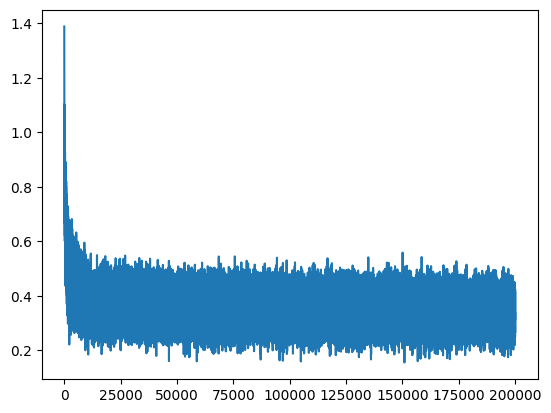

In [184]:
plt.plot(stepi, lossi)

In [178]:
# evaluate on train set 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr)
print(f'train set loss:{loss}')

train set loss:2.2364752292633057


In [179]:
# evaluate on dev set 
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev)
print(f'train set loss:{loss}')

train set loss:2.2600901126861572


* Now the problem can be:
    * mini-batch size too low
    * 3 words is not enough as the input
    * change embedding 
    * change the hidden neurons
    * lr and decay

In [180]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kmyah.
seel.
nihahalayethastendrarg.
adelynneliah.
miloe.
leighausonnarahayzion.
kamin.
shabvisthiriel.
kindretelipanthona.
usten.
dariyah.
faeha.
kaysh.
stelah.
halianayahsun.
zakelven.
mattre.
kiveaiah.
pradi.
